### QUESTION 4: 

Design a regression model using any features from the papers you find or other new features you may find useful for this problem. Fit your model on the data of each hashtag and report fitting MSE and significance of features.

#### Ans:

We will consider below features:

* Average impressions = total impressions / total tweets (for a particular hour)
* Average ranking score = total ranking / total tweets (for a particular hour)
* Average User Passivity(for original user) = total passivity / total tweets (for a particular hour)

In [1]:
hash_tags = ['#gohawks','#gopatriots','#nfl','#patriots','#sb49','#superbowl']

In [2]:
import pickle

def save_object(data, fileName):
    with open('pynb_data/'+fileName + ".pickle", 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def load_object(fileName):
    try:
        with open('pynb_data/'+fileName + ".pickle", 'rb') as f:
            data = pickle.load(f)
            return data
    except IOError:
        print("Could not read file: " + fileName)

In [3]:
import json

def getMinAndMaxTs(tag):
    filename = 'data/tweets_'+tag+'.txt'
    max_ts = 0
    min_ts = 1552522378
    with open(filename) as f:
        for line in f:
            json_object = json.loads(line)
            timestamp = json_object['citation_date']
            if(timestamp < min_ts):                
                min_ts = timestamp
            
            if(timestamp > max_ts):
                max_ts = timestamp
                
    return [min_ts,max_ts]

tagsToMinTs = {}
tagsToMaxTs = {}
for tag in hash_tags:
    ts_list = getMinAndMaxTs(tag)
    tagsToMinTs[tag] = (ts_list[0])
    tagsToMaxTs[tag] = (ts_list[1])    

In [4]:
import math
from datetime import date, timedelta
import datetime
import pytz
import json


def getLocalHour(timestamp):
    d = datetime.datetime.fromtimestamp(timestamp)
    pst = pytz.timezone('America/Los_Angeles')
    d = pst.localize(d)
    return d.hour

def getWindowNumber(start_ts, curr_ts, window):
    elapsed = (curr_ts - start_ts)/(window*1.0)
    windowNum = math.ceil(elapsed)
    return windowNum    

#https://stackoverflow.com/questions/2315032/how-do-i-find-missing-dates-in-a-list-of-sorted-dates
def getAllDays(dayStrList):
    dayList = [ datetime.datetime.strptime(x, '%Y:%m:%d') for x in dayStrList ]    
    irange = [i for i in range((dayList[-1] - dayList[0]).days)]
    irange.append(irange[-1]+1)    
    allDaysList = sorted(list(set(dayList[0] + timedelta(x) for x in irange)))
    allDayStrList = [ ('{}:{}:{}'.format(d.year,d.month,d.day)) for d in allDaysList ]
    return allDayStrList

# https://arxiv.org/pdf/1401.2018v2.pdf
def getUserPassivity(user,ts):
    createdDateTimeObj = datetime.datetime.strptime(user['created_at'],"%a %b %d %H:%M:%S %z %Y")
    created = datetime.datetime.fromtimestamp(createdDateTimeObj.timestamp())
    d = datetime.datetime.fromtimestamp(ts)
    td = (created - d).days
    statuses_count = user['statuses_count']
    return td/(1.0+statuses_count)
    
def getFeatures(tag,start_ts,end_ts,window):
    windowToTweets = {}
    windowToRetweets = {}
    windowToFollowerCount = {}
    windowToMaxFollowers = {}
    windowToRankingMetricSum = {}
    windowToImpressionsMetricSum = {}
    windowToUserPassivitySum= {}
    features = []
    labels = []
    
    filename = 'data/tweets_'+tag+'.txt'
    with open(filename) as f:
        for line in f:
            json_object = json.loads(line)
            timestamp = json_object['citation_date']
            
            if timestamp < start_ts or timestamp > end_ts:                            
                continue
                
            key = getWindowNumber(start_ts,timestamp,window)

            if key not in windowToTweets.keys():
                windowToTweets[key]=0
            windowToTweets[key]+=1
            
            retweetCount = json_object['metrics']['citations']['total']        
            
            if key not in windowToRetweets.keys():
                windowToRetweets[key]=0
            windowToRetweets[key]+=retweetCount
        
            followerCount = json_object['author']['followers']
            if key not in windowToFollowerCount.keys():
                windowToFollowerCount[key]=0
            windowToFollowerCount[key]+=followerCount
            
            if key not in windowToMaxFollowers.keys():
                windowToMaxFollowers[key]=0
            windowToMaxFollowers[key] = max(windowToMaxFollowers[key],followerCount)
            
            if key not in windowToUserPassivitySum.keys():
                windowToUserPassivitySum[key]=0.0
            windowToUserPassivitySum[key]+=getUserPassivity(json_object['tweet']['user'],timestamp)
            
            if key not in windowToRankingMetricSum.keys():
                windowToRankingMetricSum[key]=0.0
            windowToRankingMetricSum[key]+=json_object['metrics']['ranking_score']
            
            if key not in windowToImpressionsMetricSum.keys():
                windowToImpressionsMetricSum[key]=0.0
            windowToImpressionsMetricSum[key]+=json_object['metrics']['impressions']
            
            
            
        for period in range(start_ts,end_ts,window):
            key = getWindowNumber(start_ts,period,window)

            tweetCount = windowToTweets.get(key, 0)
            retweetCount = windowToRetweets.get(key,0)
            followerCount = windowToFollowerCount.get(key,0)
            maxFollowers = windowToMaxFollowers.get(key,0)
            
            if tweetCount > 0:
                avgRanking = windowToRankingMetricSum.get(key,0)/tweetCount
                avgImpressions = windowToImpressionsMetricSum.get(key,0)/tweetCount
                avgUserPassivity = windowToUserPassivitySum.get(key,0)/tweetCount                
            else:
                avgRanking = 0
                avgImpressions = 0
                avgUserPassivity = 0
        
            h = getLocalHour(period)


            feature = [tweetCount, retweetCount, followerCount, maxFollowers, avgRanking,avgImpressions,avgUserPassivity, h]
            features.append(feature)
            nextKey = getWindowNumber(start_ts, period + window, window)
            labels.append(windowToTweets.get(nextKey,0))
                
    return features,labels

In [5]:
import math
import statsmodels.api as sm
import statsmodels.tools.eval_measures as ste

for tag in hash_tags:
    tp1_start_ts = 3600 * math.floor(tagsToMinTs[tag]/(3600*1.0))
    tp1_end_ts = 3600 * math.ceil(tagsToMaxTs[tag]/(3600*1.0))
    print("Started building feature vectors for {}".format(tag))
    features,labels = getFeatures(tag,tp1_start_ts,tp1_end_ts,3600)
    save_object(features,'q4features_{}'.format(tag))
    save_object(labels,'q4labels_{}'.format(tag))
    print("Finished building feature vectors for {}".format(tag))
    
    print('\nLinear Regression Model for {}'.format(tag))
    X_orig = features
    y = labels
    
    #     https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b
    X = sm.add_constant(X_orig)
    
    model = sm.OLS(y,X)
    results = model.fit()
    pred_y = results.predict(X)

    print("\nMSE : {}".format(ste.mse(pred_y, y,axis=0)))
    print("\nMSE(from mse_resid) : {}".format(results.mse_resid))
    print("R-squared : {}".format(results.rsquared))    
    print("P values for the features are \n {} \n\n".format(results.pvalues))

    print(results.summary())
    print('---'*20)
    print('\n\n')

Started building feature vectors for #gohawks
Finished building feature vectors for #gohawks

Linear Regression Model for #gohawks

MSE : 753473.3064423524

MSE(from mse_resid) : 765370.2533861795
R-squared : 0.47907040388785194
P values for the features are 
 [7.71540292e-01 1.75562289e-14 1.45881348e-03 1.87630946e-02
 8.88498231e-01 6.08946615e-01 2.47666189e-01 8.58201585e-01
 4.32939182e-01] 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     65.52
Date:                Fri, 22 Mar 2019   Prob (F-statistic):           8.39e-76
Time:                        12:55:41   Log-Likelihood:                -4739.2
No. Observations:                 579   AIC:                             9496.
Df Residuals:                     570   BIC:

Finished building feature vectors for #patriots

Linear Regression Model for #patriots

MSE : 5156233.041647749

MSE(from mse_resid) : 5236520.407348147
R-squared : 0.6694513174511216
P values for the features are 
 [6.24822373e-01 9.77892682e-34 2.19017823e-01 5.69295698e-01
 7.27263314e-02 7.34041421e-01 2.32369503e-01 9.66656561e-01
 8.98833990e-01] 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     146.3
Date:                Fri, 22 Mar 2019   Prob (F-statistic):          1.42e-133
Time:                        12:56:52   Log-Likelihood:                -5369.2
No. Observations:                 587   AIC:                         1.076e+04
Df Residuals:                     578   BIC:                         1.080e+04
Df Model: 

### QUESTION 5: 
For each of the top 3 features (i.e. with the smallest p-values) in your mea- surements, draw a scatter plot of predictant (number of tweets for next hour) versus value of that feature, using all the samples you have extracted, and analyze it.
Do the regression coefficients agree with the trends in the plots? If not, why?


Most important features(lowest p-values) for #gohawks
 followerCount
 retweetCount
 tweetCount
Pvalue for feature followerCount for #gohawks is 0.018763094599543294
Coefficient for feature followerCount for #gohawks is -0.00018847132621599227


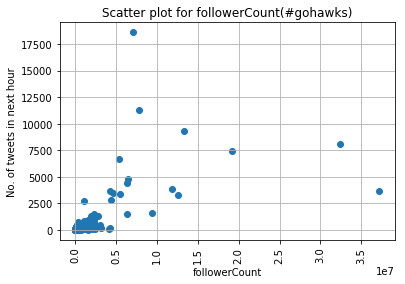

Pvalue for feature retweetCount for #gohawks is 0.0014588134824458244
Coefficient for feature retweetCount for #gohawks is -0.13911821302130534


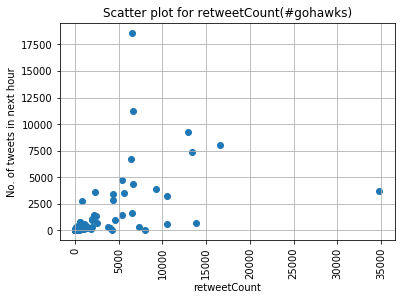

Pvalue for feature tweetCount for #gohawks is 1.7556228869362186e-14
Coefficient for feature tweetCount for #gohawks is 1.2924060743834471


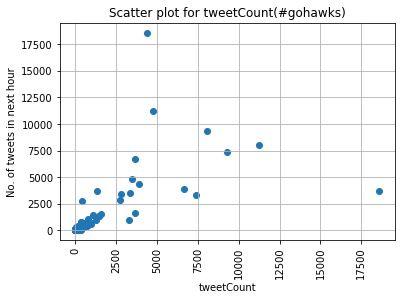

------------------------------------------------------------




Most important features(lowest p-values) for #gopatriots
 retweetCount
 tweetCount
 avgRanking
Pvalue for feature retweetCount for #gopatriots is 0.01283282928532465
Coefficient for feature retweetCount for #gopatriots is 0.4796963253867693


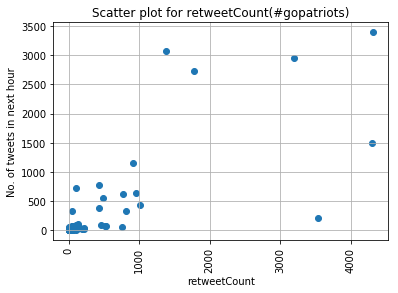

Pvalue for feature tweetCount for #gopatriots is 0.27945898550949166
Coefficient for feature tweetCount for #gopatriots is 0.3091782225051255


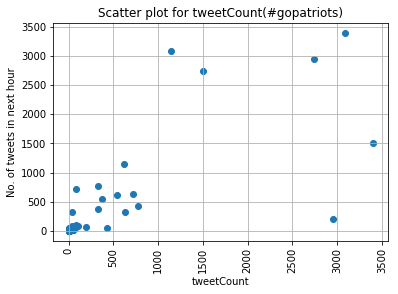

Pvalue for feature avgRanking for #gopatriots is 0.5718427212555451
Coefficient for feature avgRanking for #gopatriots is 2.094215859832104


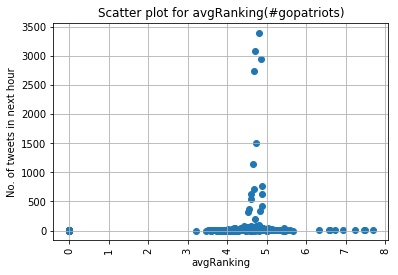

------------------------------------------------------------




Most important features(lowest p-values) for #nfl
 followerCount
 tweetCount
 maxFollowers
Pvalue for feature followerCount for #nfl is 4.78478809456836e-06
Coefficient for feature followerCount for #nfl is 0.00011772805514730039


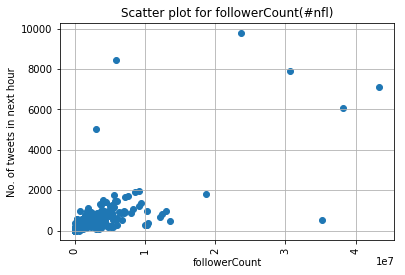

Pvalue for feature tweetCount for #nfl is 8.11056619664898e-05
Coefficient for feature tweetCount for #nfl is 0.5500326739813628


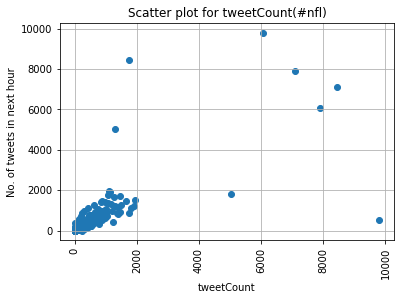

Pvalue for feature maxFollowers for #nfl is 0.0019844132100121964
Coefficient for feature maxFollowers for #nfl is -0.0001183883900308835


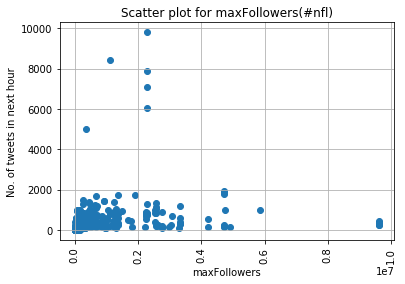

------------------------------------------------------------




Most important features(lowest p-values) for #patriots
 maxFollowers
 tweetCount
 retweetCount
Pvalue for feature maxFollowers for #patriots is 0.07272633144556
Coefficient for feature maxFollowers for #patriots is 0.00019841892117786121


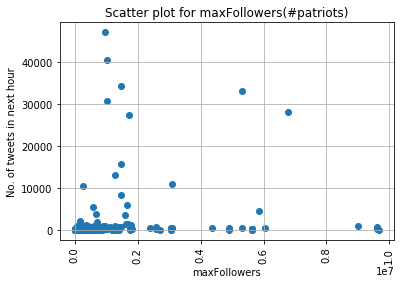

Pvalue for feature tweetCount for #patriots is 9.778926821341795e-34
Coefficient for feature tweetCount for #patriots is 0.9167884657267295


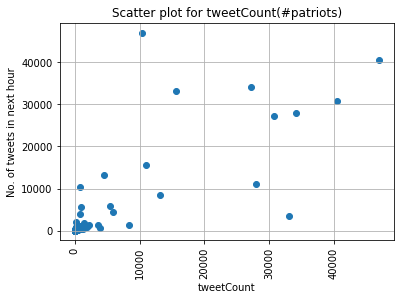

Pvalue for feature retweetCount for #patriots is 0.21901782349224727
Coefficient for feature retweetCount for #patriots is -0.07118902607050373


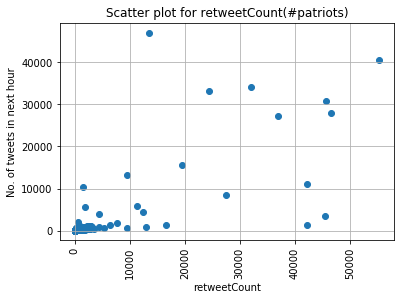

------------------------------------------------------------




Most important features(lowest p-values) for #sb49
 maxFollowers
 tweetCount
 retweetCount
Pvalue for feature maxFollowers for #sb49 is 0.012831111487830893
Coefficient for feature maxFollowers for #sb49 is 0.00012049708389332586


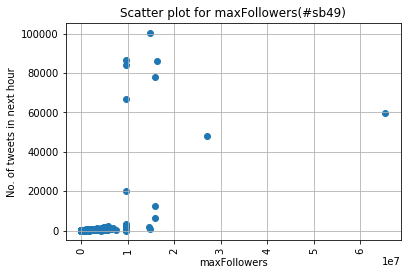

Pvalue for feature tweetCount for #sb49 is 8.962670051267918e-35
Coefficient for feature tweetCount for #sb49 is 1.1474654888981048


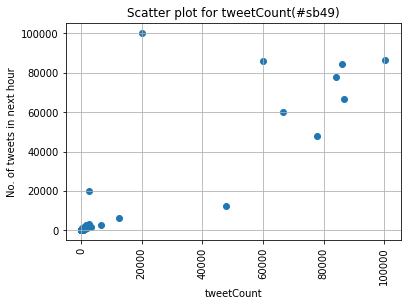

Pvalue for feature retweetCount for #sb49 is 0.024208278456942723
Coefficient for feature retweetCount for #sb49 is -0.17867617095076255


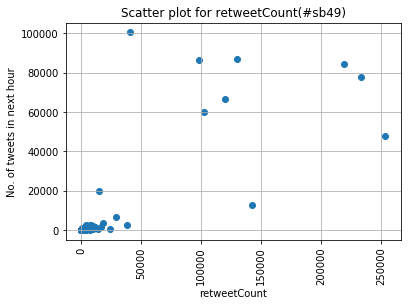

------------------------------------------------------------




Most important features(lowest p-values) for #superbowl
 tweetCount
 followerCount
 maxFollowers
Pvalue for feature tweetCount for #superbowl is 3.0864015680293793e-112
Coefficient for feature tweetCount for #superbowl is 2.3045699413703624


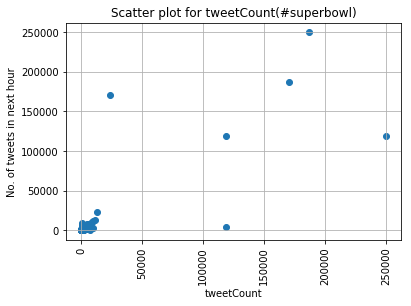

Pvalue for feature followerCount for #superbowl is 3.4426215741897817e-11
Coefficient for feature followerCount for #superbowl is -0.00014743429128887906


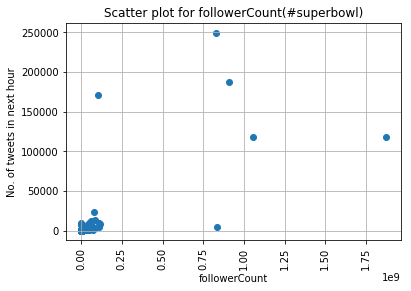

Pvalue for feature maxFollowers for #superbowl is 2.714965730465489e-07
Coefficient for feature maxFollowers for #superbowl is 0.0008184588225596705


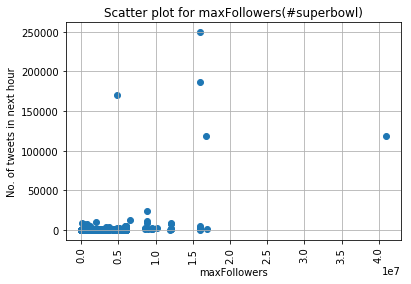

------------------------------------------------------------





In [6]:
import numpy as np
import matplotlib.pyplot as plt

index_to_feature = ['bias','tweetCount', 'retweetCount', 'followerCount', 'maxFollowers', 'avgRanking','avgImpressions','avgUserPassivity','hr']

def plotScatter(features,labels,index,tag):
    if index==0:
        return
    
    x = [f[index-1] for f in features]
    y = labels
    plt.scatter(x, y)
    plt.xlabel(index_to_feature[index])
    plt.xticks(rotation=90)
    plt.ylabel("No. of tweets in next hour")
    plt.title("Scatter plot for "+index_to_feature[index]+"("+tag+")")
    plt.grid()
    plt.show()

for tag in hash_tags:
    X_orig = load_object('q4features_{}'.format(tag))
    y = load_object('q4labels_{}'.format(tag))
    X = sm.add_constant(X_orig)

    model = sm.OLS(y,X)
    results = model.fit()
    a = np.array(results.pvalues)
#     print(results.params)
    
    ind = np.argpartition(a, 3)
    indices = ind[:3]

    print('\nMost important features(lowest p-values) for {}'.format(tag))
    for i in indices:    
        print(' '+index_to_feature[i])
        
    for i in indices:
        print("Pvalue for feature {} for {} is {}".format(index_to_feature[i],tag,results.pvalues[i]))
        print("Coefficient for feature {} for {} is {}".format(index_to_feature[i],tag,results.params[i]))
        plotScatter(X_orig,y,i,tag)
    
    print('---'*20)
    print('\n\n')
